# Model Analysis

In [1]:
from utils.model_analysis_local import * 
import os
import matplotlib.pyplot as plt
from nilearn import datasets, plotting
from PIL import Image
fsaverage = datasets.fetch_surf_fsaverage('fsaverage')

# Define Model, Subject and Image for Visualization

    these visualization are made based on predictions from the test set

In [8]:
#Change as needed
checkpoint_path = '/Users/emilykruger/Documents/GitHub/aml_project_2023/hpc/utils/trained_models/03-01-24/alexnet_LR0.0003_SAMPLES_all_SIMPLEHEAD_True_EPOCHS50_BATCHSIZE_64_TIME_2024-01-02_20:37:28.pt'
backbone = 'alexnet'
simple_head_state=True
subject_id = 3
image_id = 34

# Loading and (Pre-)Processing

In [9]:
#load images and original activations 
brain, image_paths = load_subject_data(subject_id)

#pick image and activation
image = np.load(image_paths[image_id])
image = preprocess(image)
activation = torch.Tensor(brain[image_id,:])

Shape of pca_brain:  (908, 39548)


/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [10]:
output_size = 100

# Check if GPU is available and if not, use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load in model & Create feature extractor
trained_model_state_dict = torch.load(checkpoint_path, map_location = device)
feature_extractor = torch.hub.load('utils', backbone, source = 'local')

trained_model = ResNet1HeadID(output_size = output_size, feature_extractor= feature_extractor,simple_head=simple_head_state).eval()
trained_model.load_state_dict(trained_model_state_dict["model_state_dict"])
trained_model_backbone = trained_model.feature_extractor

if backbone == "alexnet":
    output_layer_names = get_module_names(trained_model_backbone)[1:-1]
else:
    output_layer_names = get_block_names(trained_model_backbone)[:-1]

feature_extractor = create_feature_extractor(trained_model_backbone, output_layer_names)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# Visualization of Prediction and Error for one Image

## Predict Activation for One Image

In [12]:
# use loaded model from beginning and pass single image through
preds = trained_model(image.unsqueeze(0))

# inverse pca preds & drop dimension
inversed_preds = torch.Tensor(pca.inverse_transform(preds.detach().numpy())).flatten()

## Visualize Predicted and Actual Activation in Left and Right Hemisphere

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


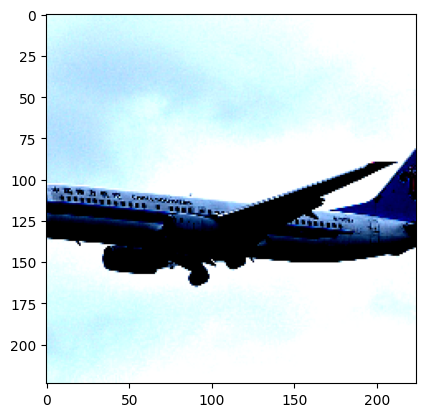

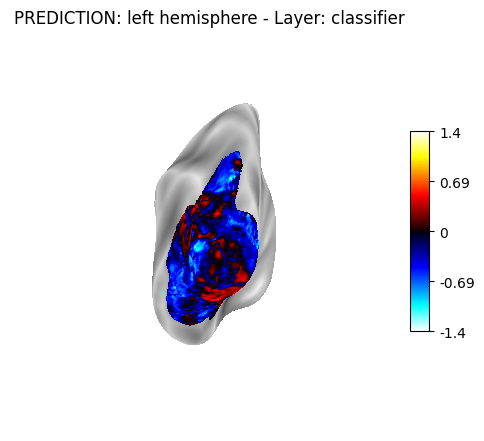

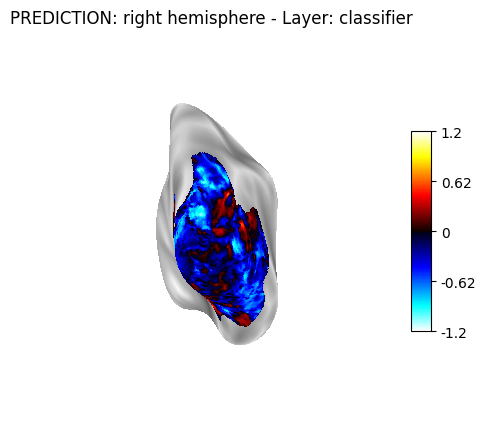

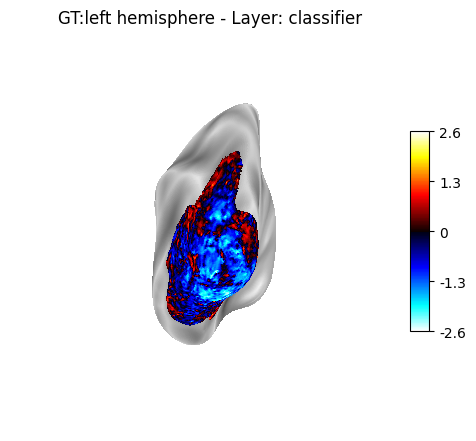

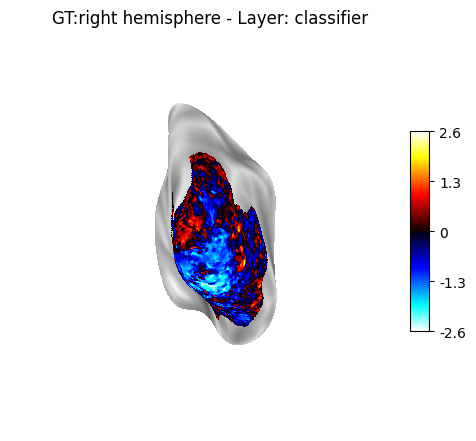

In [13]:
display(plt.imshow(image.permute(1,2,0)))

for i, act in enumerate([inversed_preds, activation]):
    for j, hem in enumerate(['left', 'right']):
        fsaverage_response_lh, fsaverage_response_rh = process_subject_data(act, 1)
        hemisphere = hem
        if hem == 'left':
            brain = fsaverage_response_lh
        else:
            brain = fsaverage_response_rh

        if i == 0:
            title = f'PREDICTION: {hem} hemisphere - Layer: {key}'
        else:
            title = f'GT:{hem} hemisphere - Layer: {key}'
        
        # Create the interactive brain surface map
        view = plotting.plot_surf_stat_map(
            surf_mesh=fsaverage['infl_'+hemisphere],
            stat_map= brain,
            bg_map=fsaverage['sulc_'+hemisphere],
            threshold=1e-14,
            cmap='cold_hot',
            colorbar=True,
            title=title,
            view = 'posterior'
        )
plt.show()

## Visualize Squared Error

In [14]:
#calculate error
errors = (inversed_preds-activation)**2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


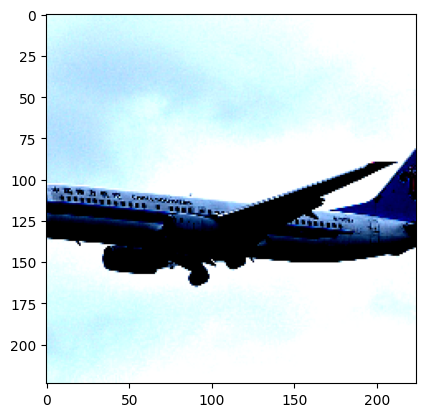

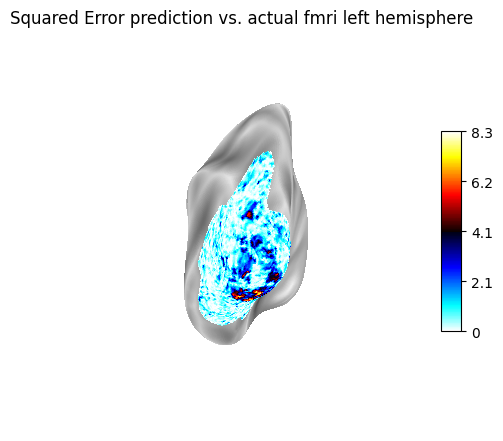

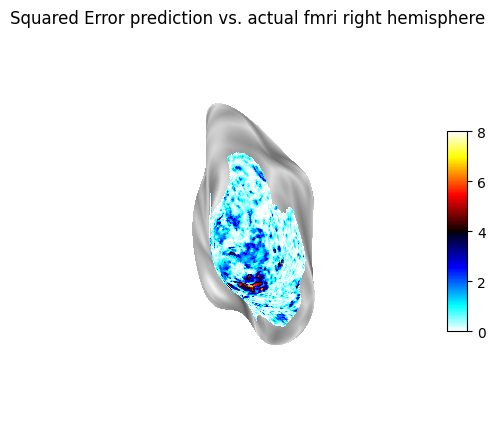

In [15]:
display(plt.imshow(image.permute(1,2,0)))

for j, hem in enumerate(['left', 'right']):
    fsaverage_response_lh, fsaverage_response_rh = process_subject_data(errors,1)
    hemisphere = hem
    if hem == 'left':
        brain = fsaverage_response_lh
    else:
        brain = fsaverage_response_rh
    
    # Create the interactive brain surface map
    view = plotting.plot_surf_stat_map(
        surf_mesh=fsaverage['infl_'+hemisphere],
        stat_map= brain,
        bg_map=fsaverage['sulc_'+hemisphere],
        threshold=1e-14,
        cmap='cold_hot',
        colorbar=True,
        title=f'Squared Error prediction vs. actual fmri {hem} hemisphere',
        view = 'posterior'
    )
plt.show()

# Visualize Correlations between Prediction and GT for ROI

## Per Subject Full Model

Shape of pca_brain:  (984, 39548)


/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Inversed Predictions Sucessfull


100%|██████████| 20544/20544 [00:09<00:00, 2134.57it/s]
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


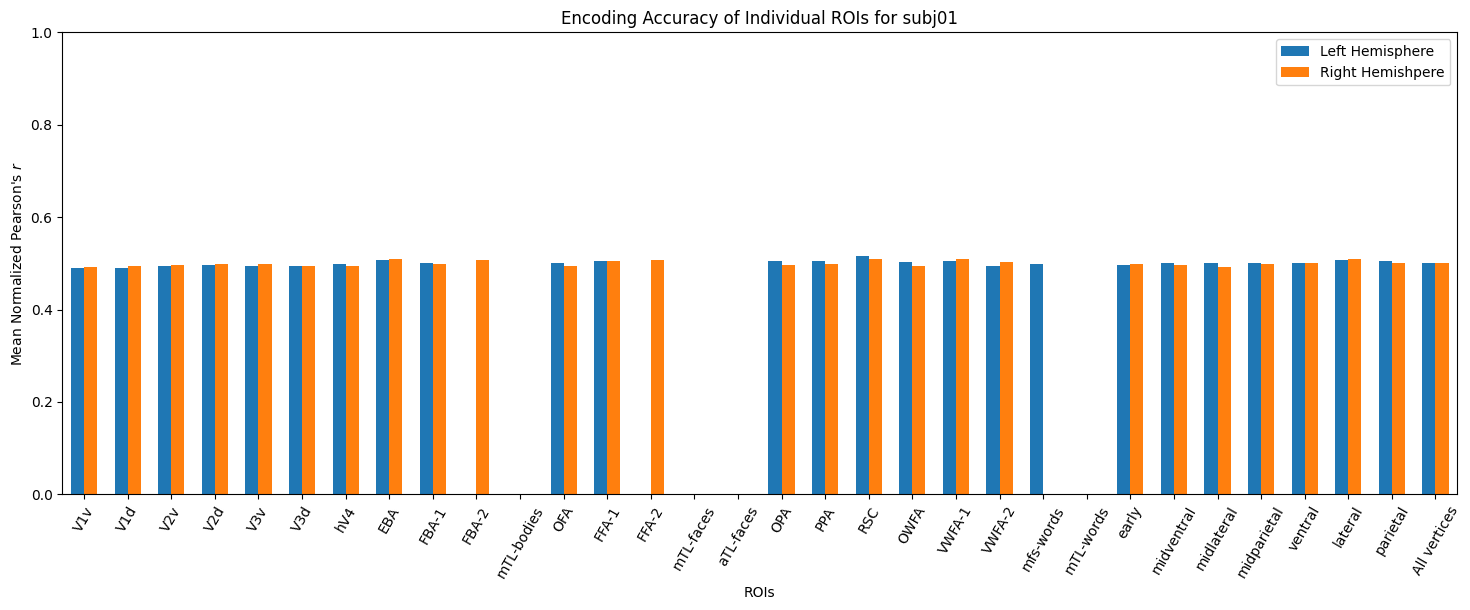

Shape of pca_brain:  (984, 39548)


/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Inversed Predictions Sucessfull


100%|██████████| 20544/20544 [00:06<00:00, 3352.94it/s]
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


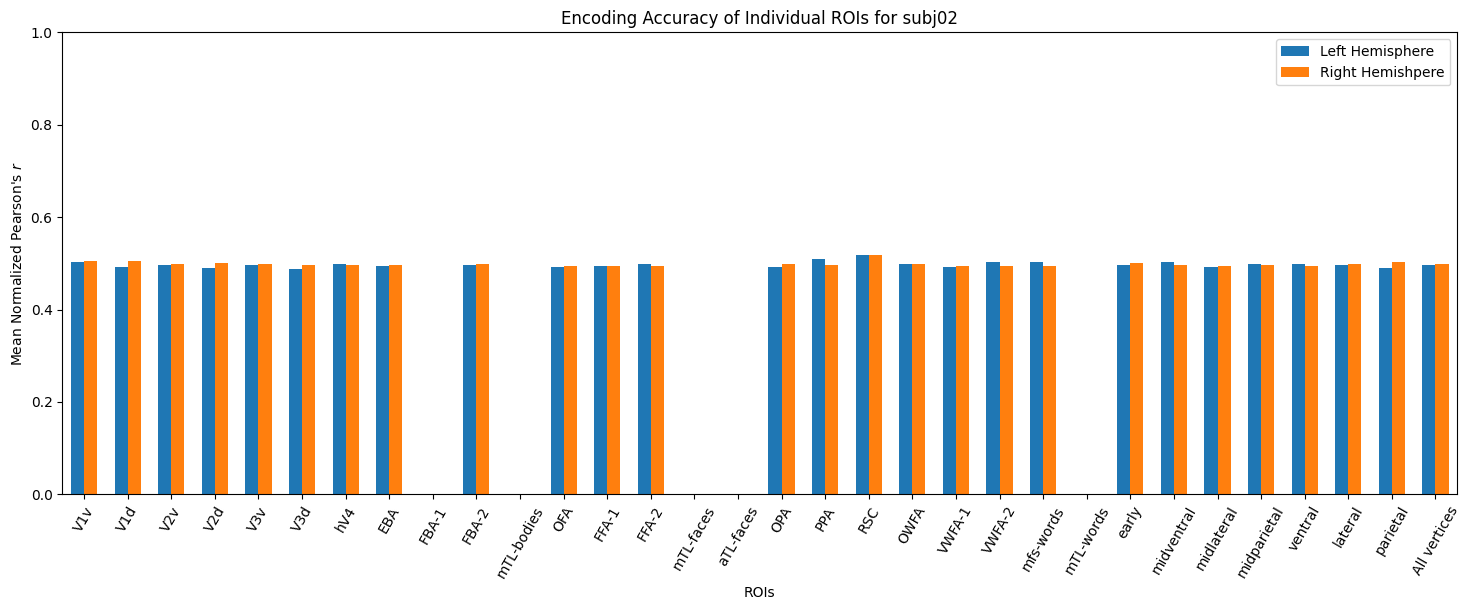

Shape of pca_brain:  (908, 39548)


/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Inversed Predictions Sucessfull


100%|██████████| 20544/20544 [00:06<00:00, 3232.38it/s]
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


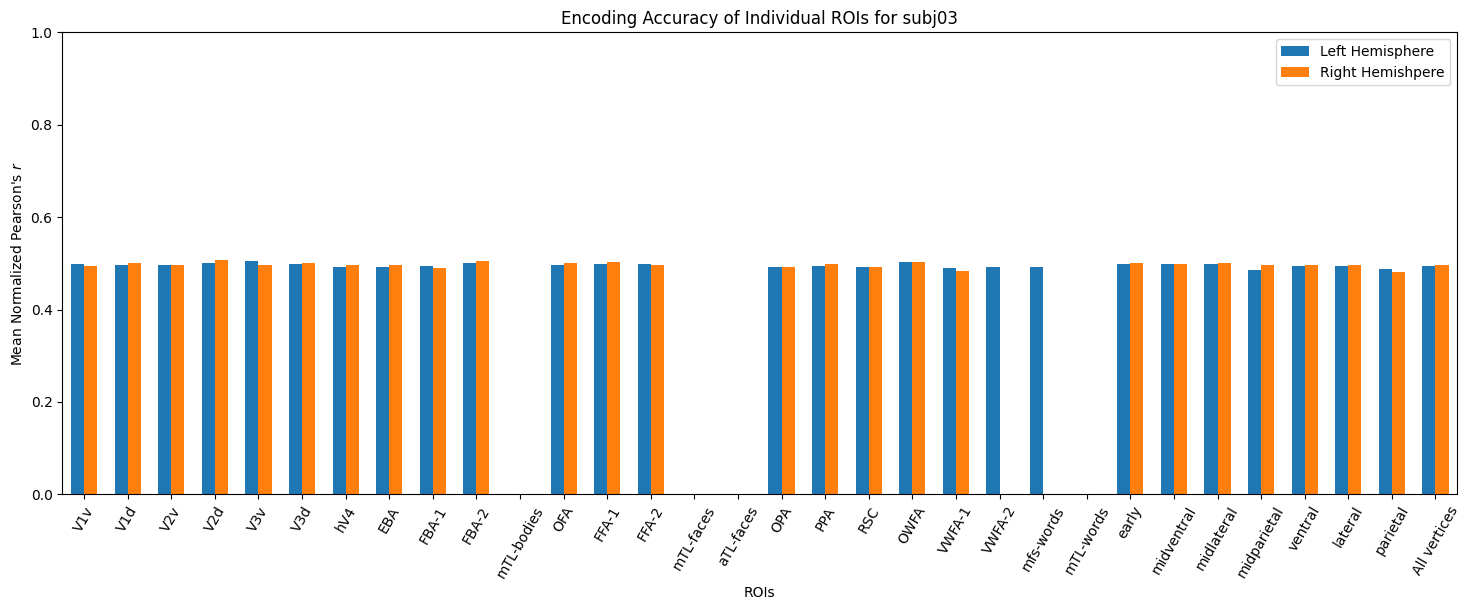

Shape of pca_brain:  (877, 39548)


/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Inversed Predictions Sucessfull


100%|██████████| 20544/20544 [00:06<00:00, 3423.95it/s]
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


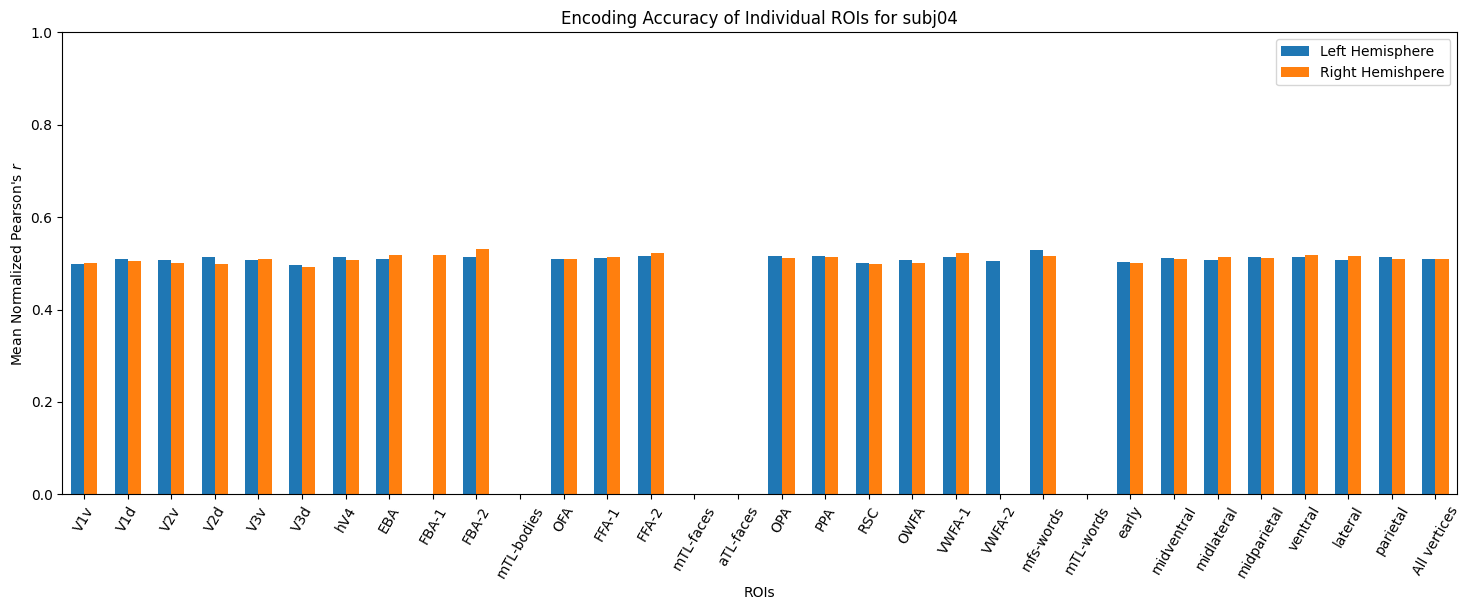

Shape of pca_brain:  (984, 39548)


/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Inversed Predictions Sucessfull


100%|██████████| 20544/20544 [00:06<00:00, 3331.86it/s]
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


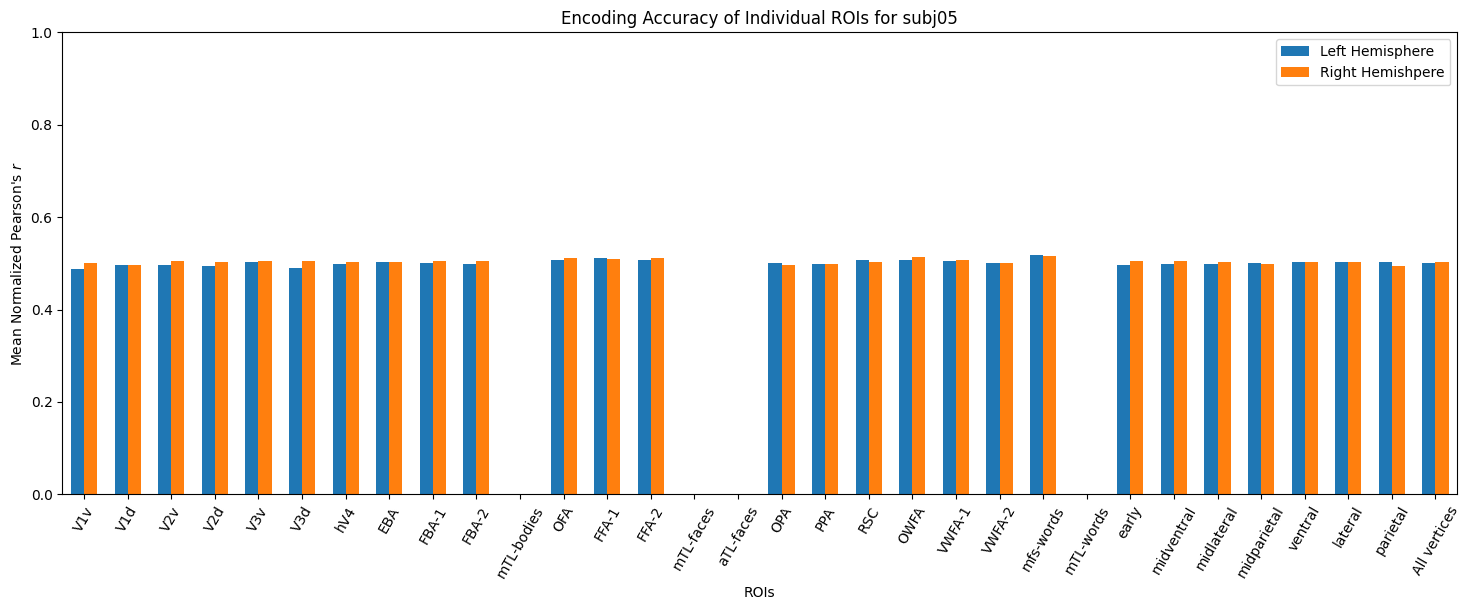

Shape of pca_brain:  (908, 39198)


/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Inversed Predictions Sucessfull


100%|██████████| 20220/20220 [00:06<00:00, 3221.14it/s]
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


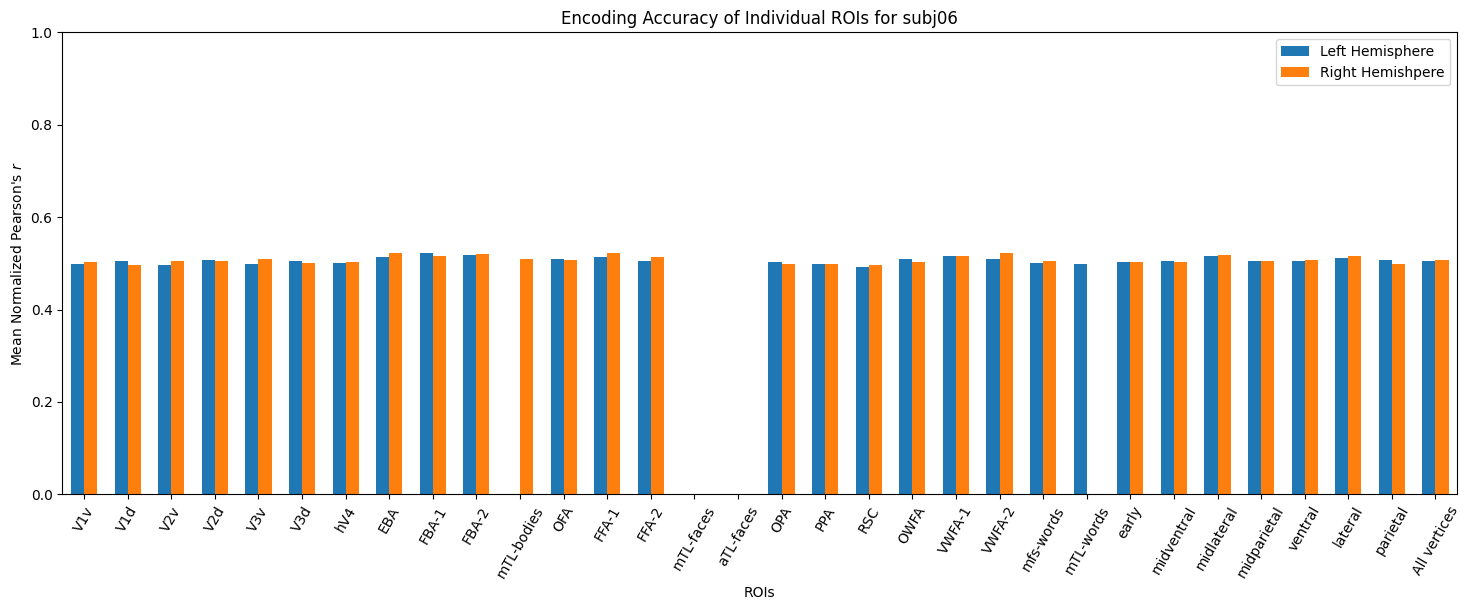

Shape of pca_brain:  (984, 39548)


/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Inversed Predictions Sucessfull


100%|██████████| 20544/20544 [00:06<00:00, 3297.17it/s]
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


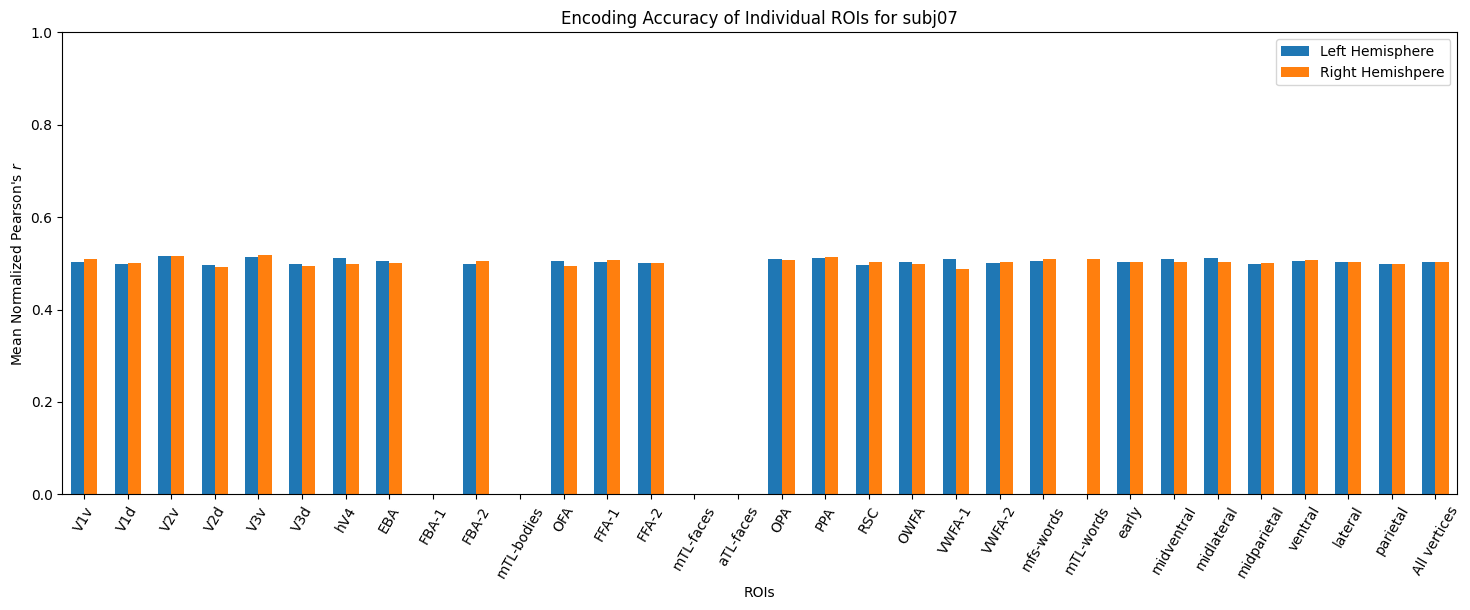

Shape of pca_brain:  (877, 39511)


/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Inversed Predictions Sucessfull


100%|██████████| 20530/20530 [00:05<00:00, 3519.65it/s]
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


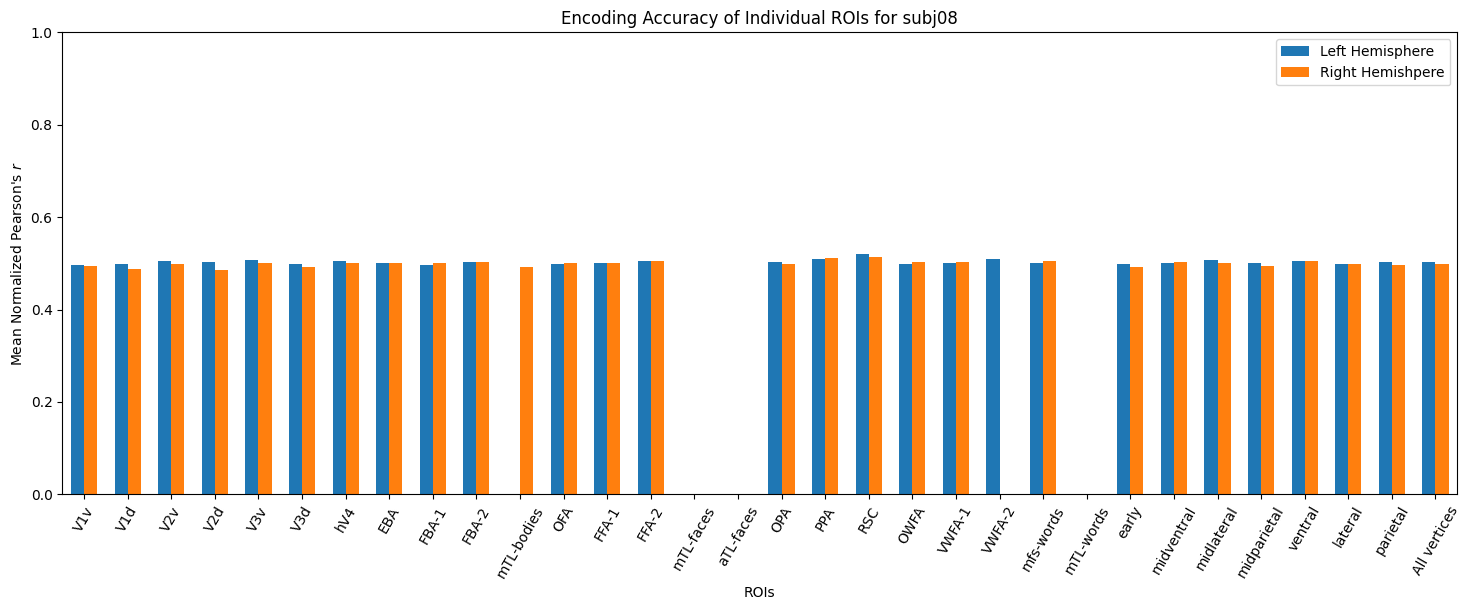

In [4]:
for subject_id in list(range(1,8+1)):
    # load images and original activations 
    brain, image_paths = load_subject_data(subject_id)

    # pick image and activation
    images = []
    for i in range(len(image_paths)):
        image = np.load(image_paths[i])
        image = preprocess(image)
        images.append(image)
    activation = torch.Tensor(brain)

    # Inverse transform of preds with frozen PCA models
    pca = get_pca_model(subject_id)

    # use loaded model from beginning and pass image through
    preds = np.zeros(activation.shape)
    for i, img in enumerate(images):
        pred = trained_model(img.unsqueeze(0))
        inversed_pred = pca.inverse_transform(pred.detach().numpy()).flatten()
        preds[i,:] = inversed_pred

    predictions = torch.Tensor(preds)
    print('Inversed Predictions Sucessfull')

    corr_roi_plot(gt_activation=activation, pred_activation=predictions, subject=subject_id)

## Averaged over All Subjects Full Model

Shape of pca_brain:  (984, 39548)


/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Inversed Predictions Sucessfull


100%|██████████| 20544/20544 [00:05<00:00, 3446.62it/s]
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Subject 1 done.
Shape of pca_brain:  (984, 39548)
Inversed Predictions Sucessfull


100%|██████████| 20544/20544 [00:06<00:00, 3370.56it/s]


Subject 2 done.
Shape of pca_brain:  (908, 39548)
Inversed Predictions Sucessfull


100%|██████████| 20544/20544 [00:06<00:00, 3021.80it/s]


Subject 3 done.
Shape of pca_brain:  (877, 39548)
Inversed Predictions Sucessfull


100%|██████████| 20544/20544 [00:06<00:00, 3325.32it/s]


Subject 4 done.
Shape of pca_brain:  (984, 39548)
Inversed Predictions Sucessfull


100%|██████████| 20544/20544 [00:06<00:00, 3356.04it/s]


Subject 5 done.
Shape of pca_brain:  (908, 39198)
Inversed Predictions Sucessfull


100%|██████████| 20220/20220 [00:06<00:00, 3272.77it/s]


Subject 6 done.
Shape of pca_brain:  (984, 39548)
Inversed Predictions Sucessfull


100%|██████████| 20544/20544 [00:06<00:00, 3338.51it/s]


Subject 7 done.
Shape of pca_brain:  (877, 39511)
Inversed Predictions Sucessfull


100%|██████████| 20530/20530 [00:06<00:00, 3392.21it/s]


Subject 8 done.


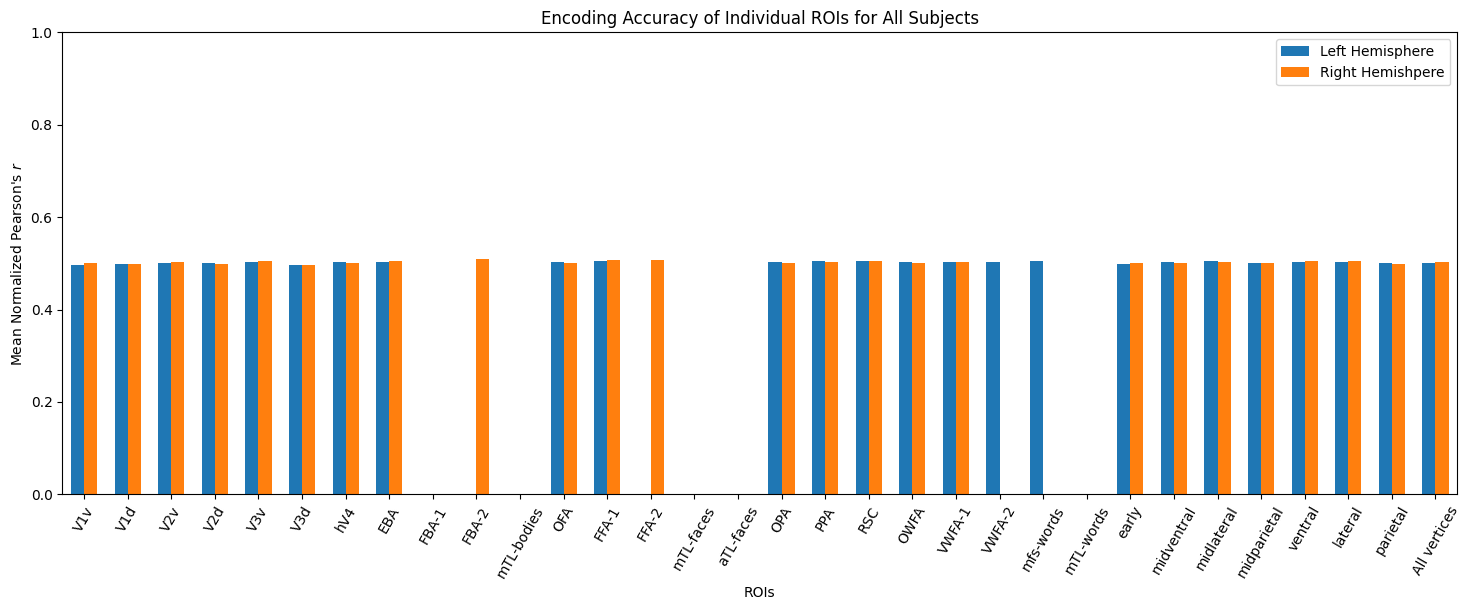

In [5]:
corr_roi_plot_allsub(list(range(1,8+1)), model = trained_model)

## Averaged over All Subjects per Layer

Shape of pca_brain:  (984, 39548)


/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 20544/20544 [00:05<00:00, 3615.03it/s]
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean 

Shape of pca_brain:  (984, 39548)


100%|██████████| 20544/20544 [00:05<00:00, 3613.21it/s]


Shape of pca_brain:  (908, 39548)


100%|██████████| 20544/20544 [00:05<00:00, 3559.42it/s]


Shape of pca_brain:  (877, 39548)


100%|██████████| 20544/20544 [00:05<00:00, 3559.32it/s]


Shape of pca_brain:  (984, 39548)


100%|██████████| 20544/20544 [00:05<00:00, 3601.06it/s]


Shape of pca_brain:  (908, 39198)


100%|██████████| 20220/20220 [00:05<00:00, 3569.62it/s]


Shape of pca_brain:  (984, 39548)


100%|██████████| 20544/20544 [00:05<00:00, 3549.11it/s]


Shape of pca_brain:  (877, 39511)


100%|██████████| 20530/20530 [00:05<00:00, 3552.80it/s]


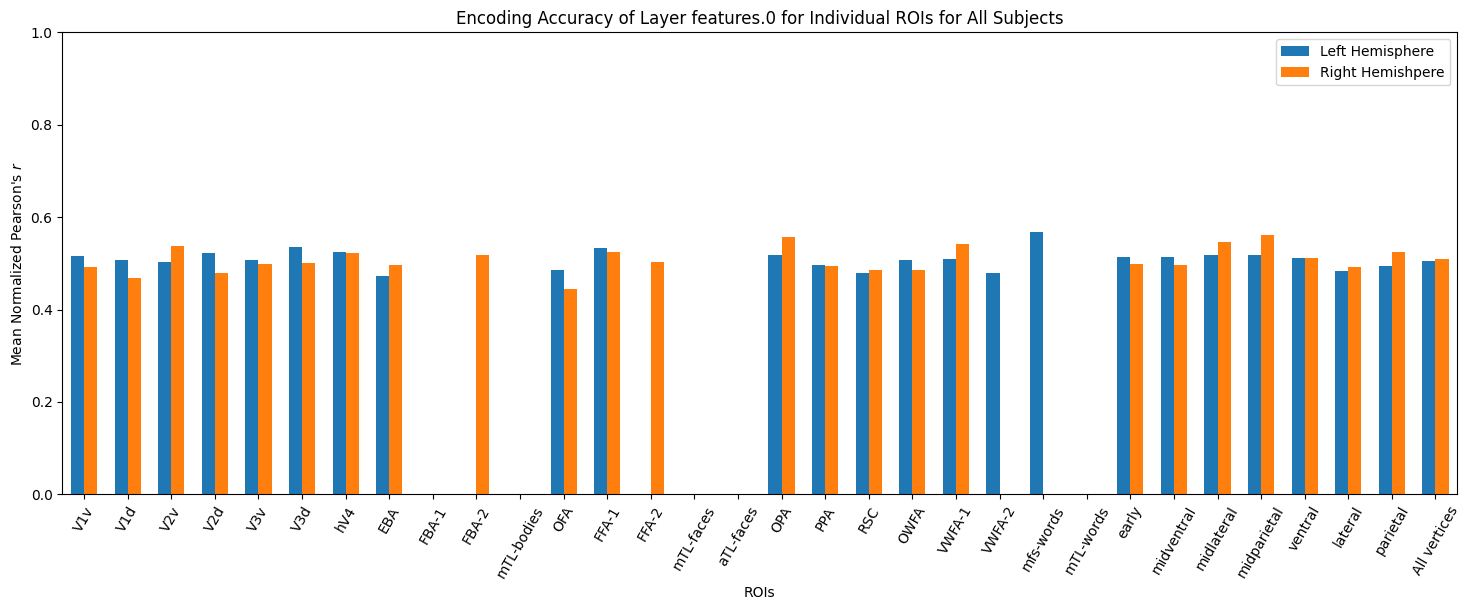

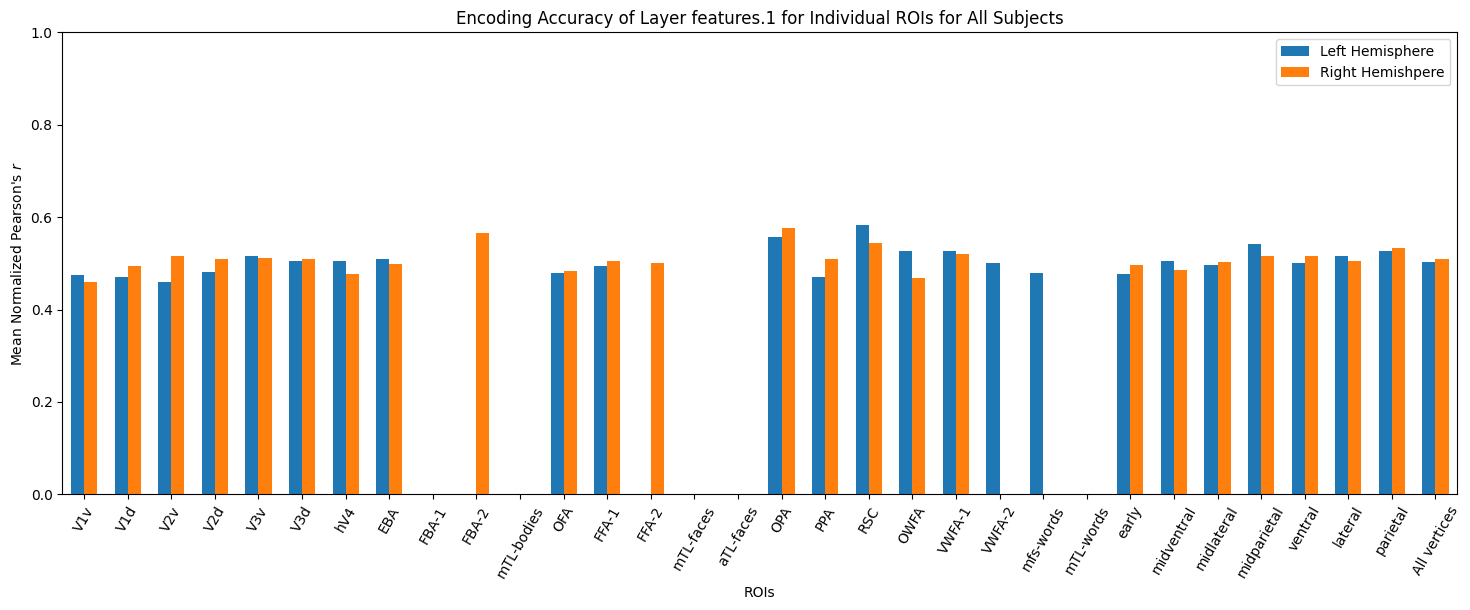

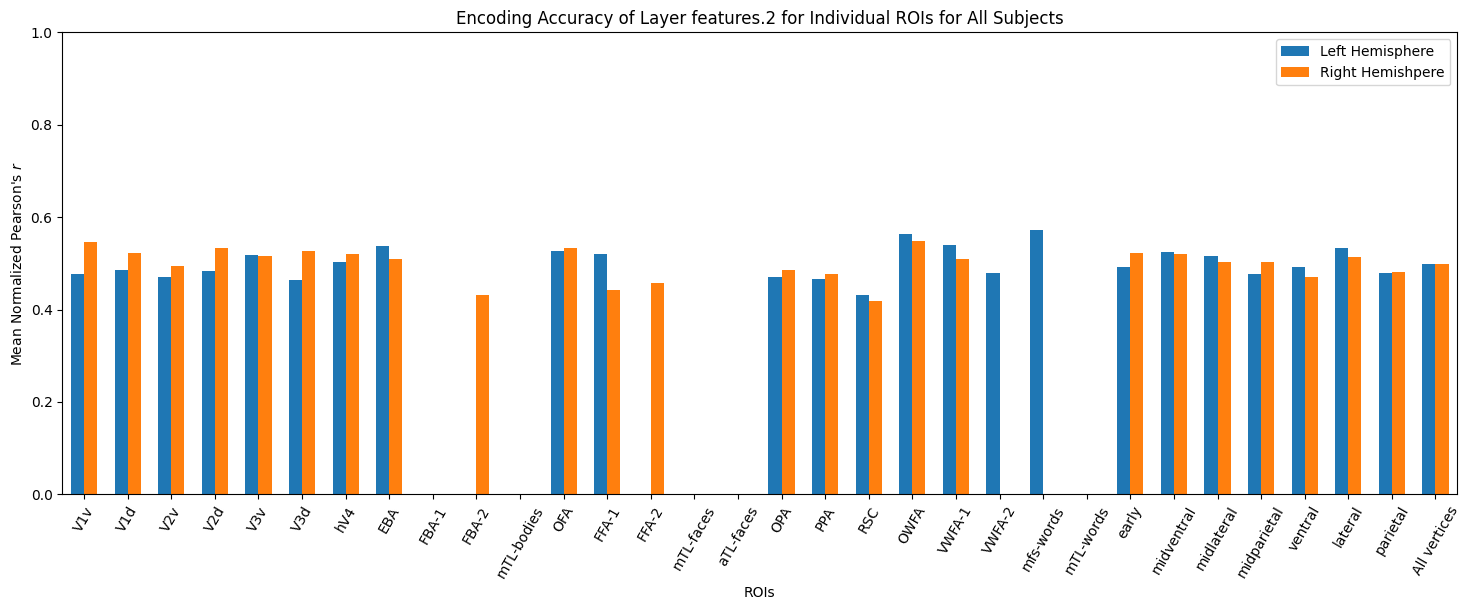

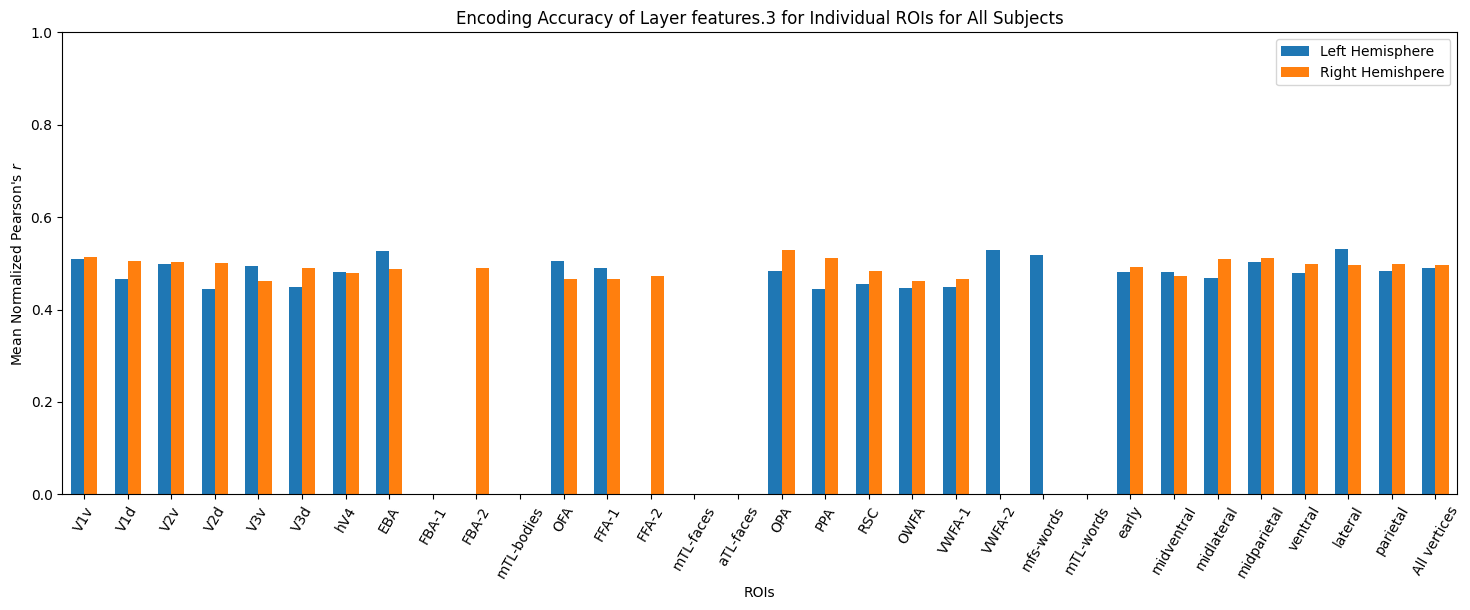

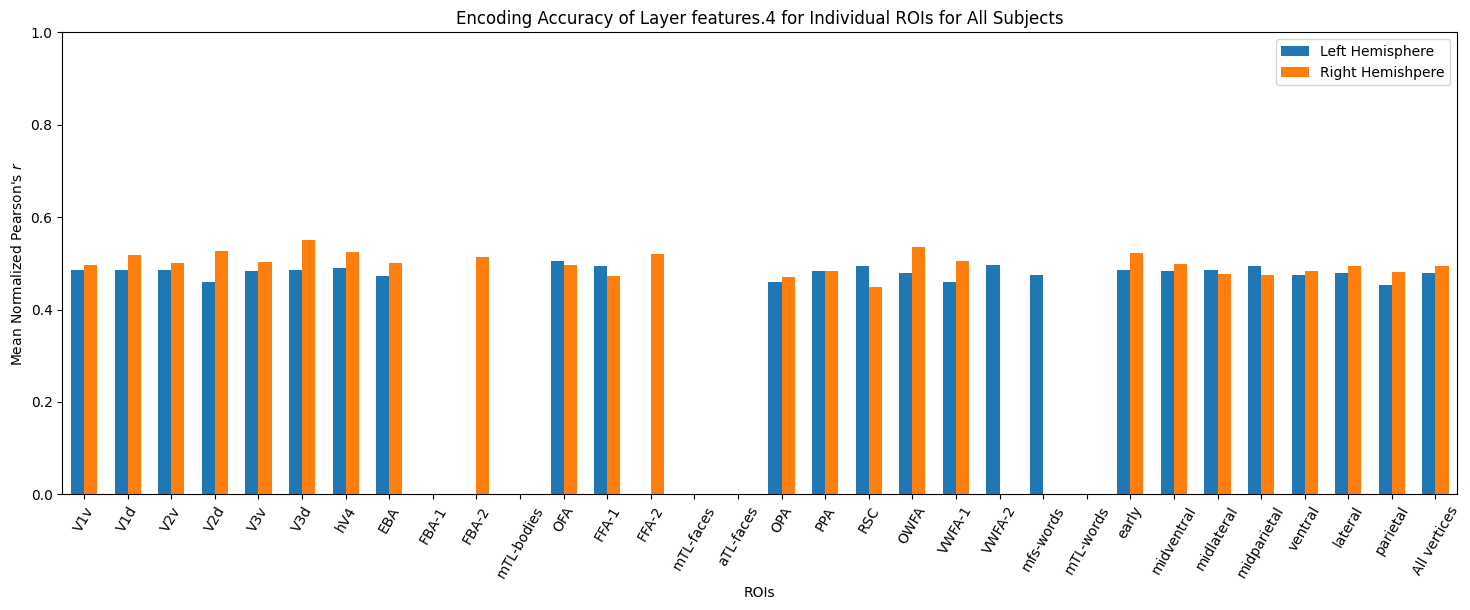

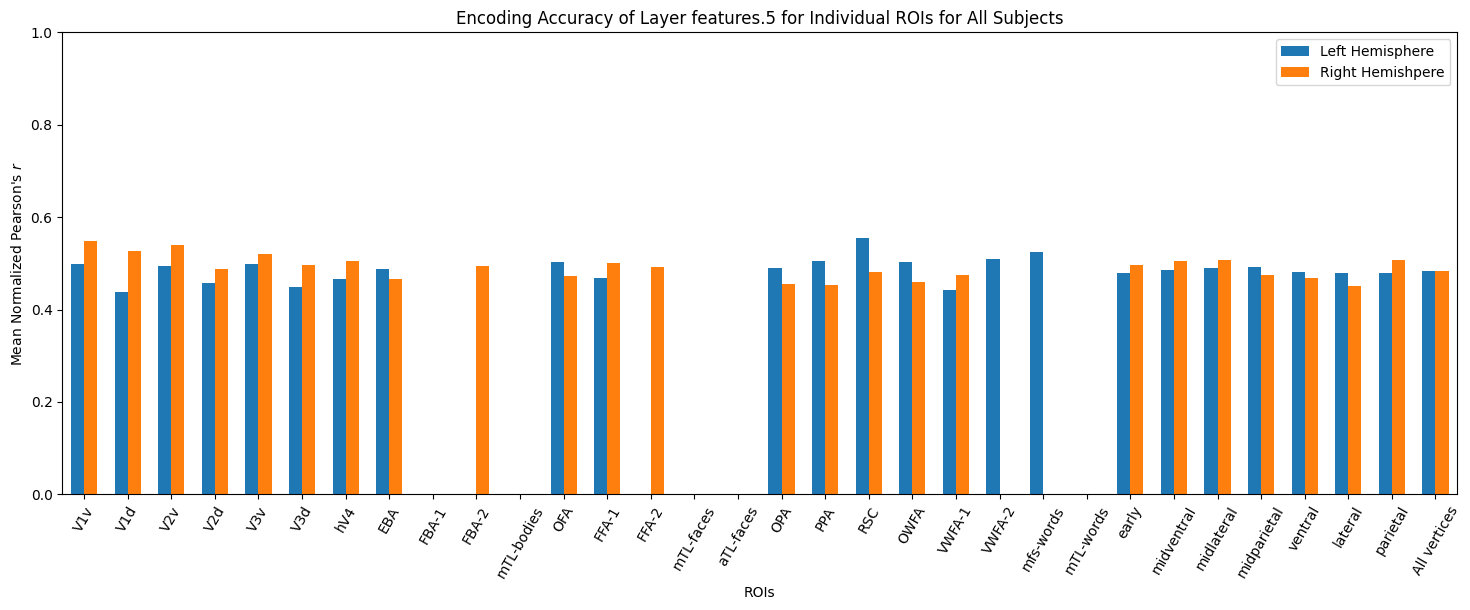

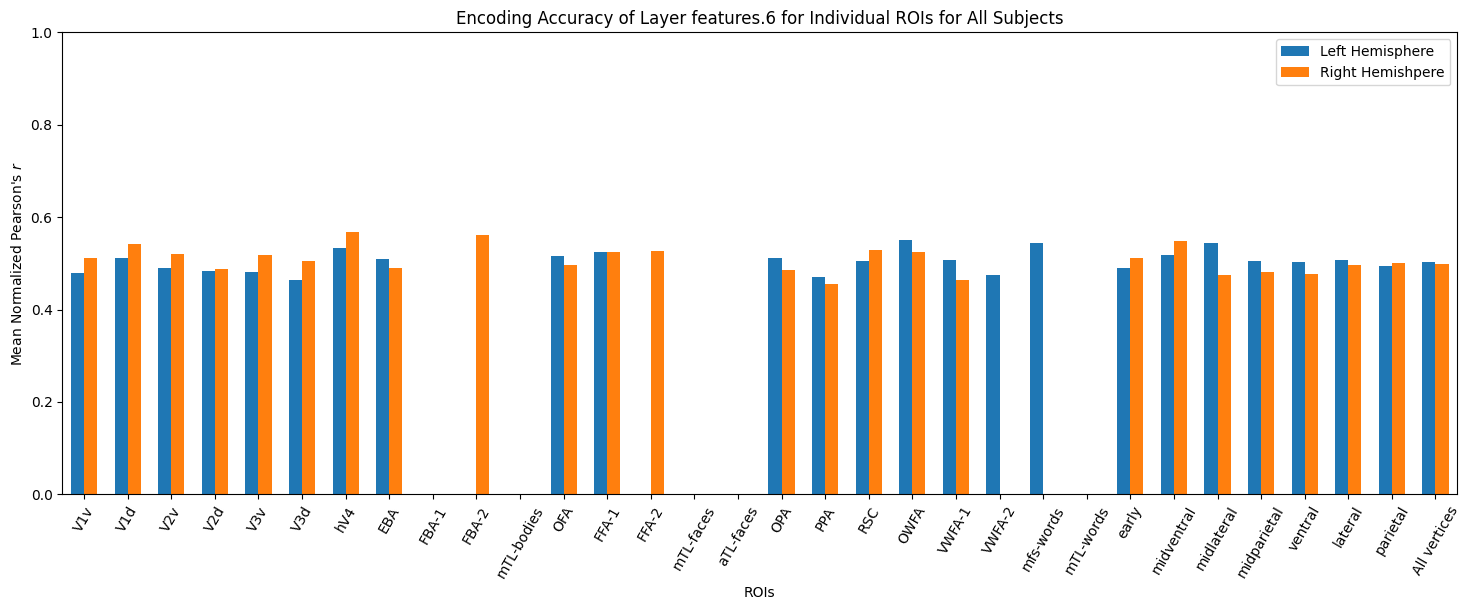

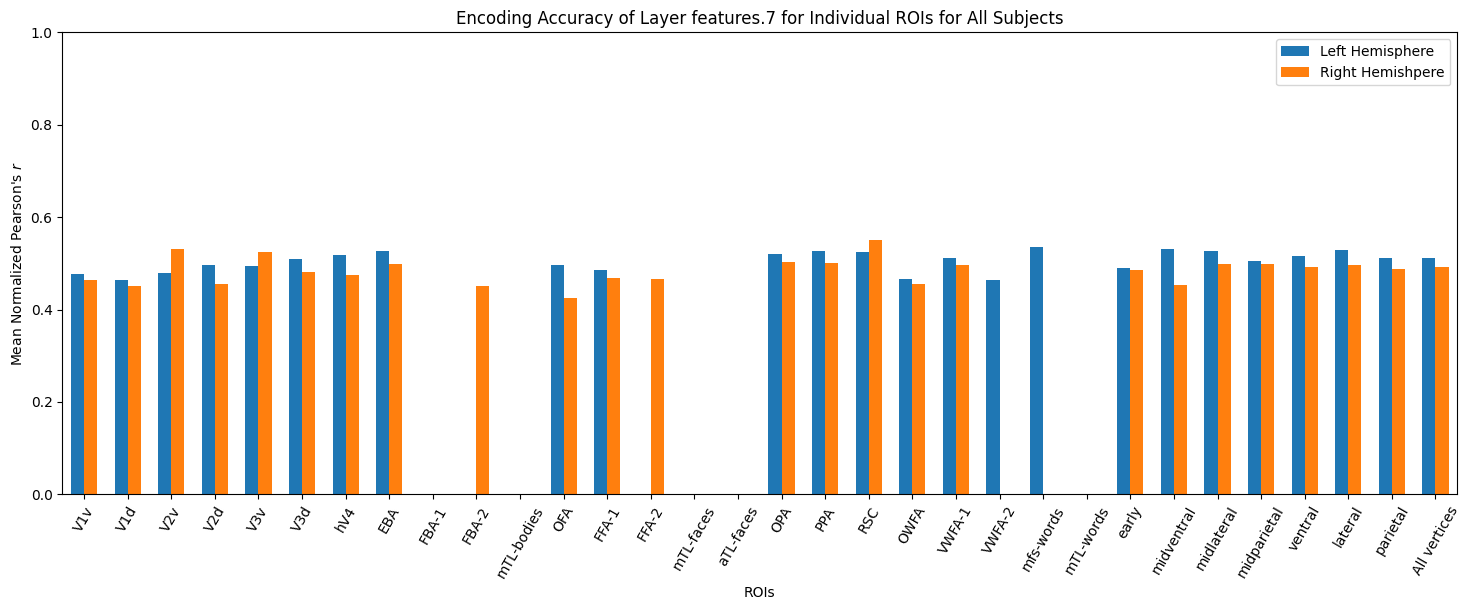

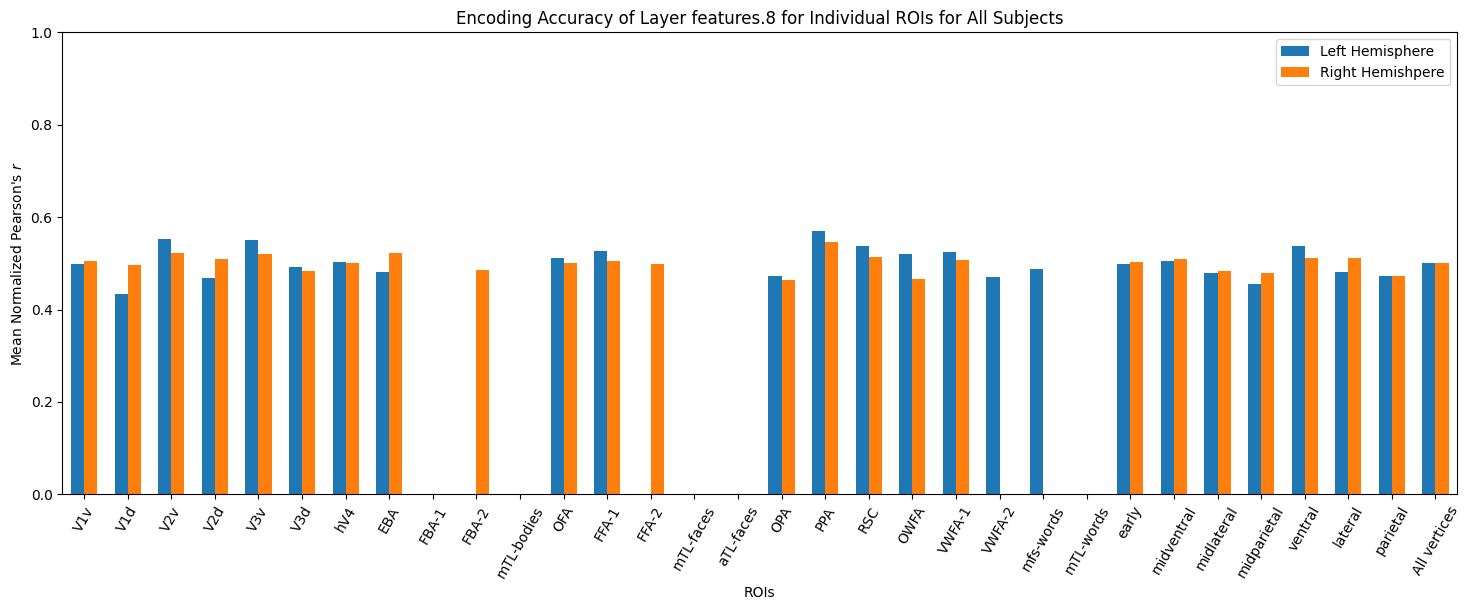

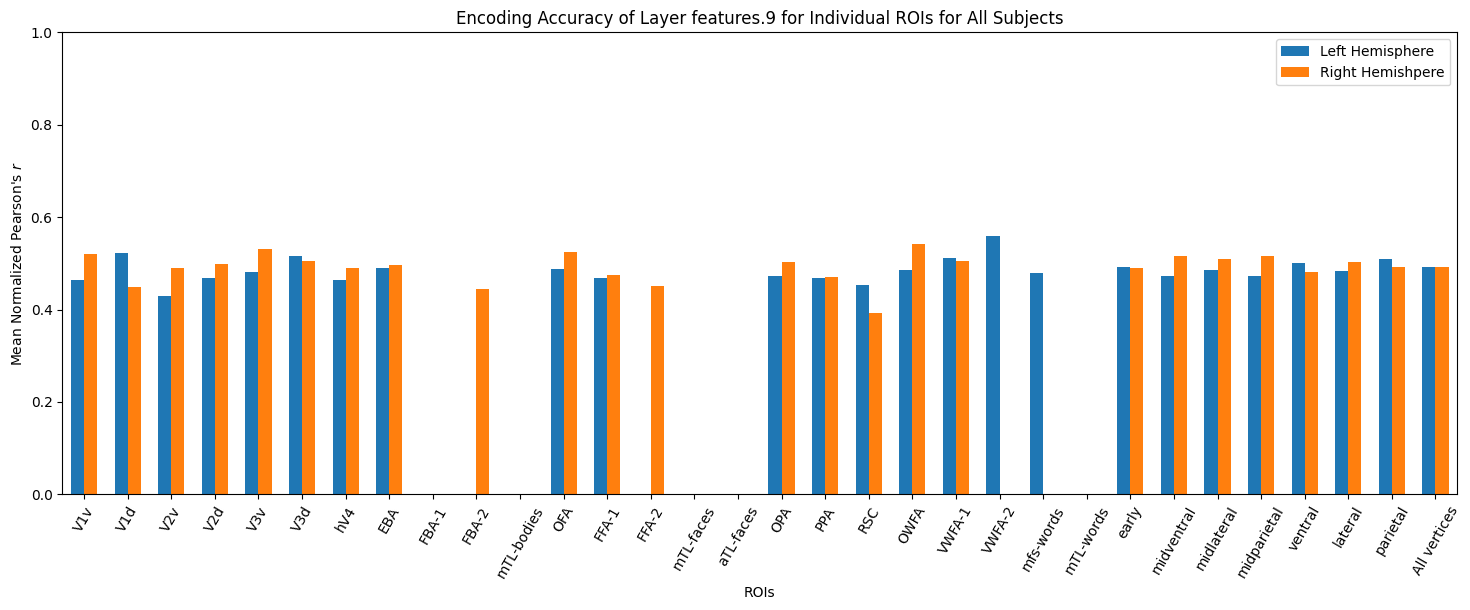

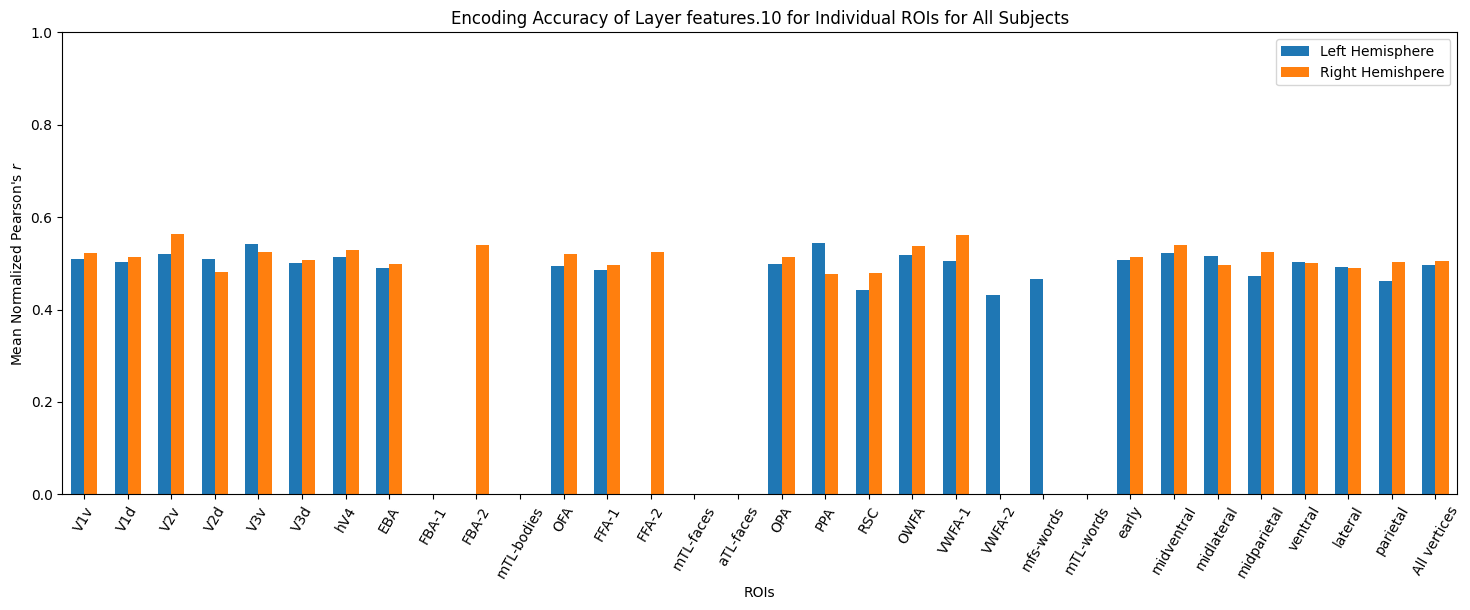

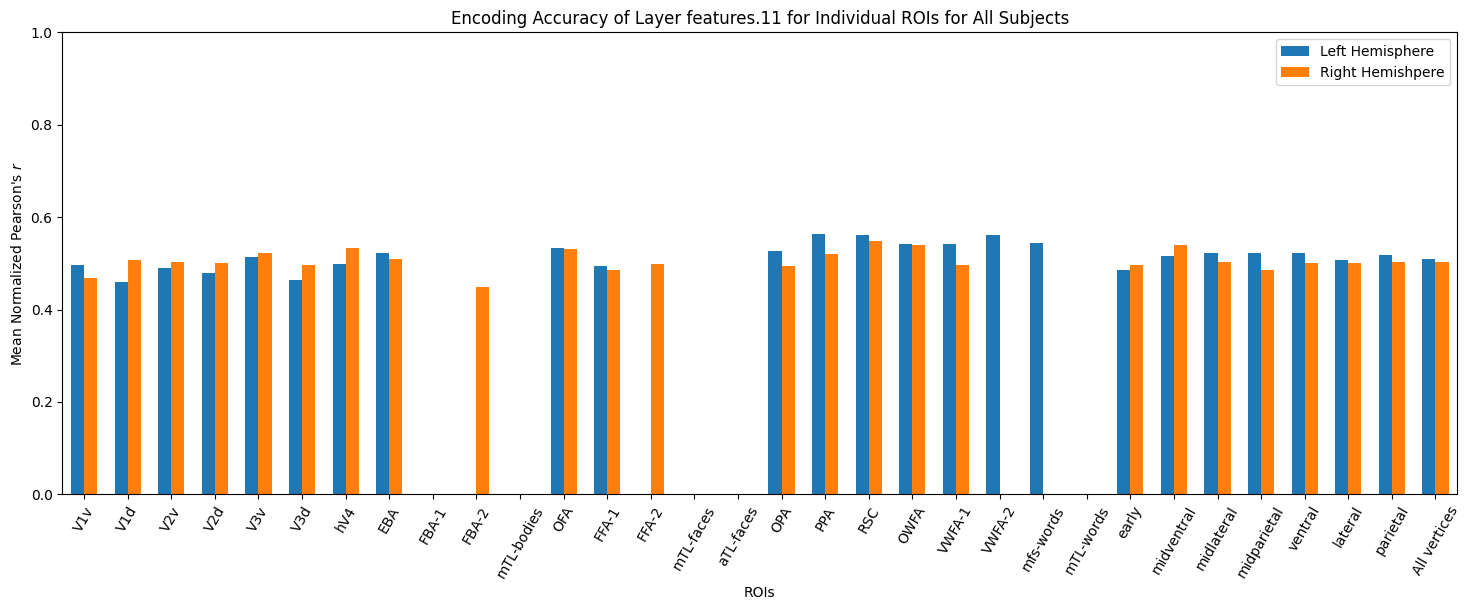

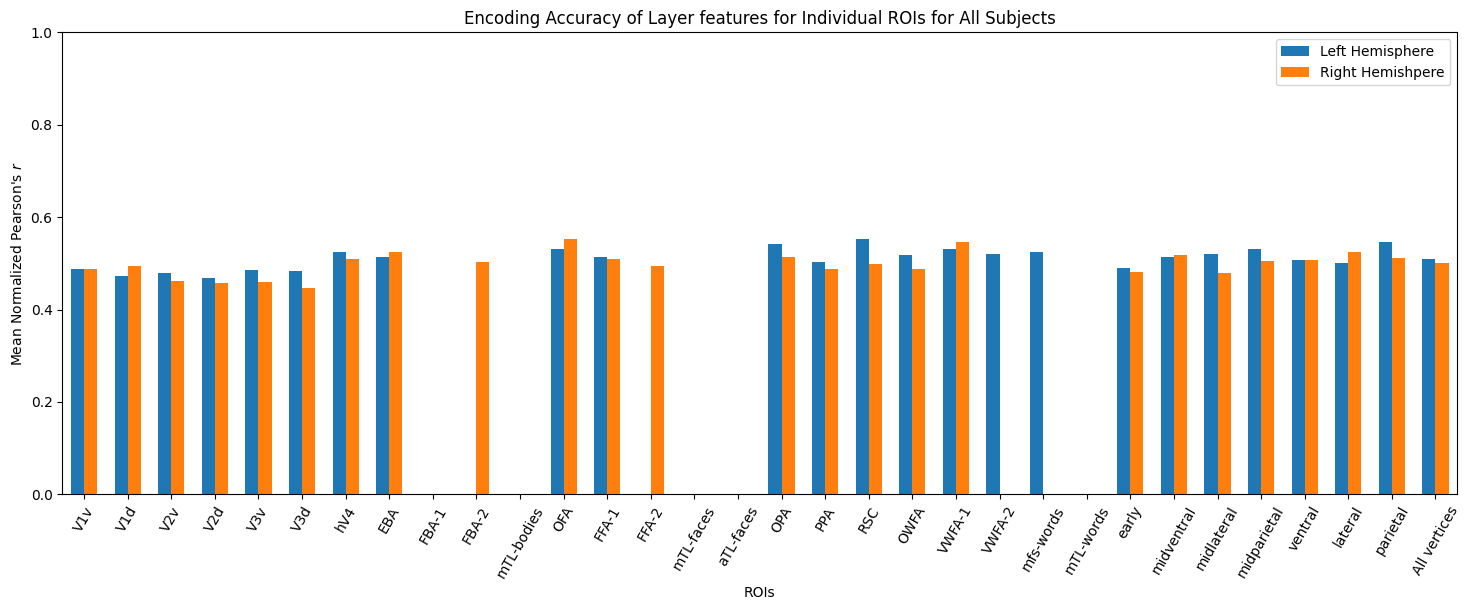

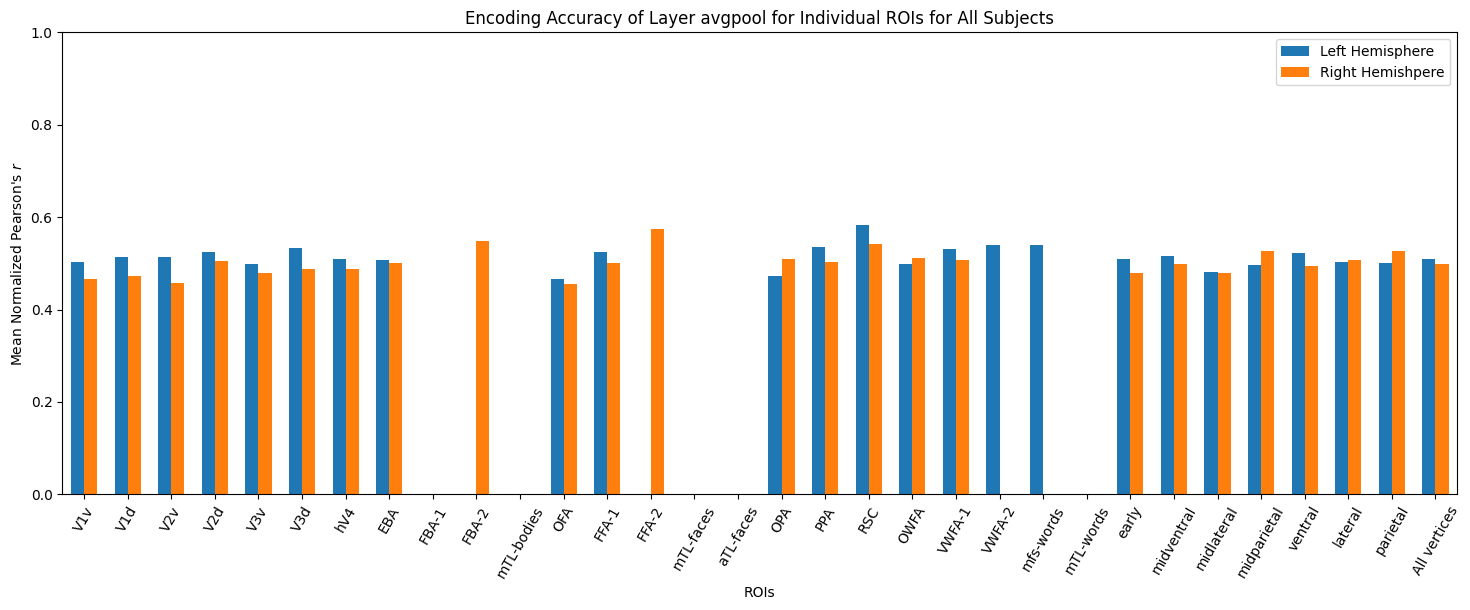

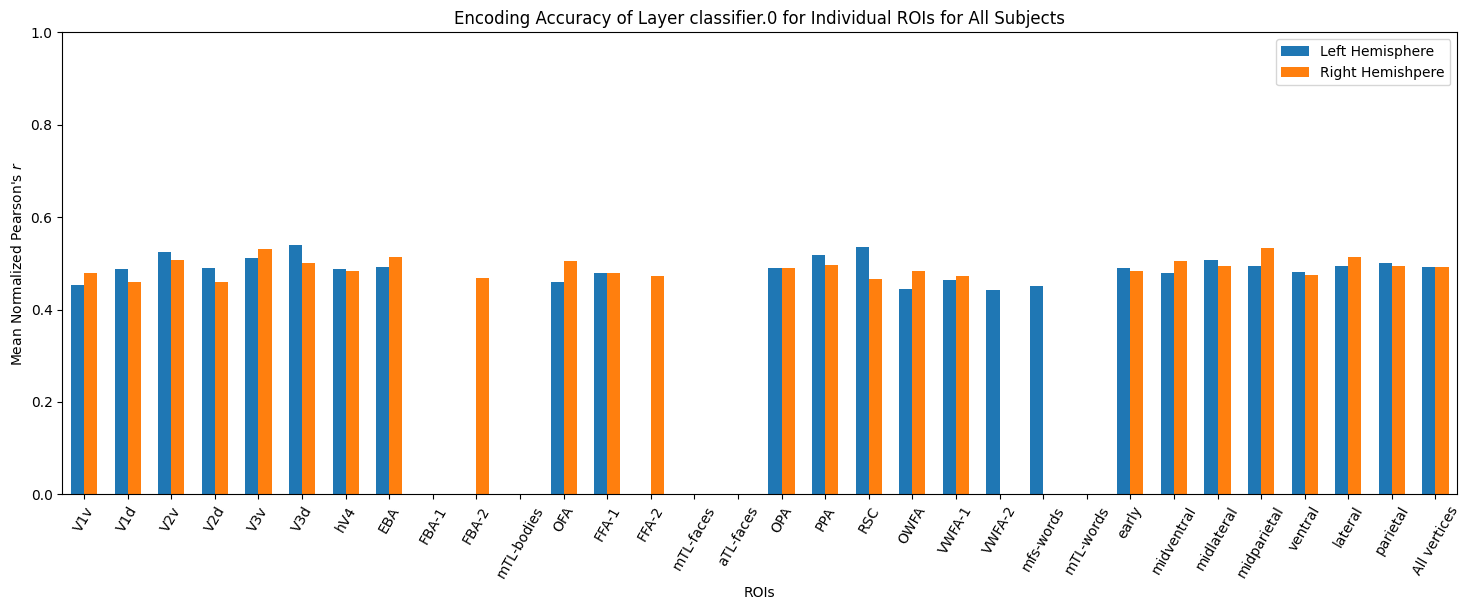

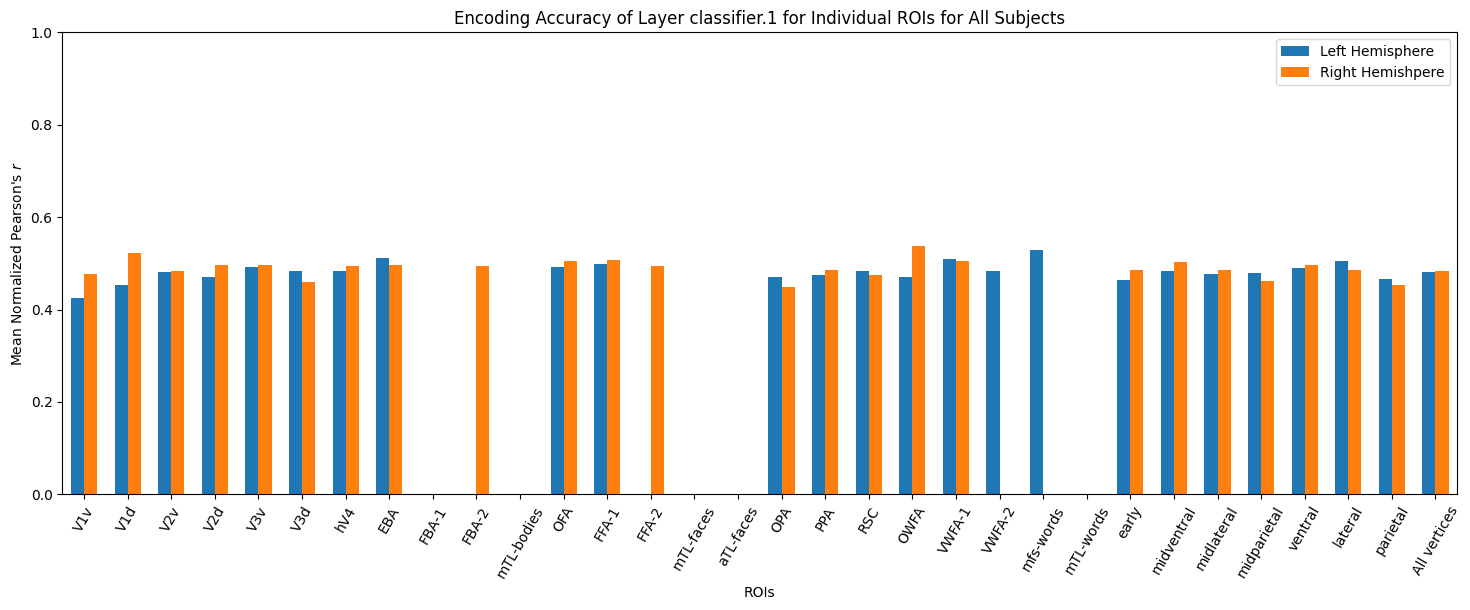

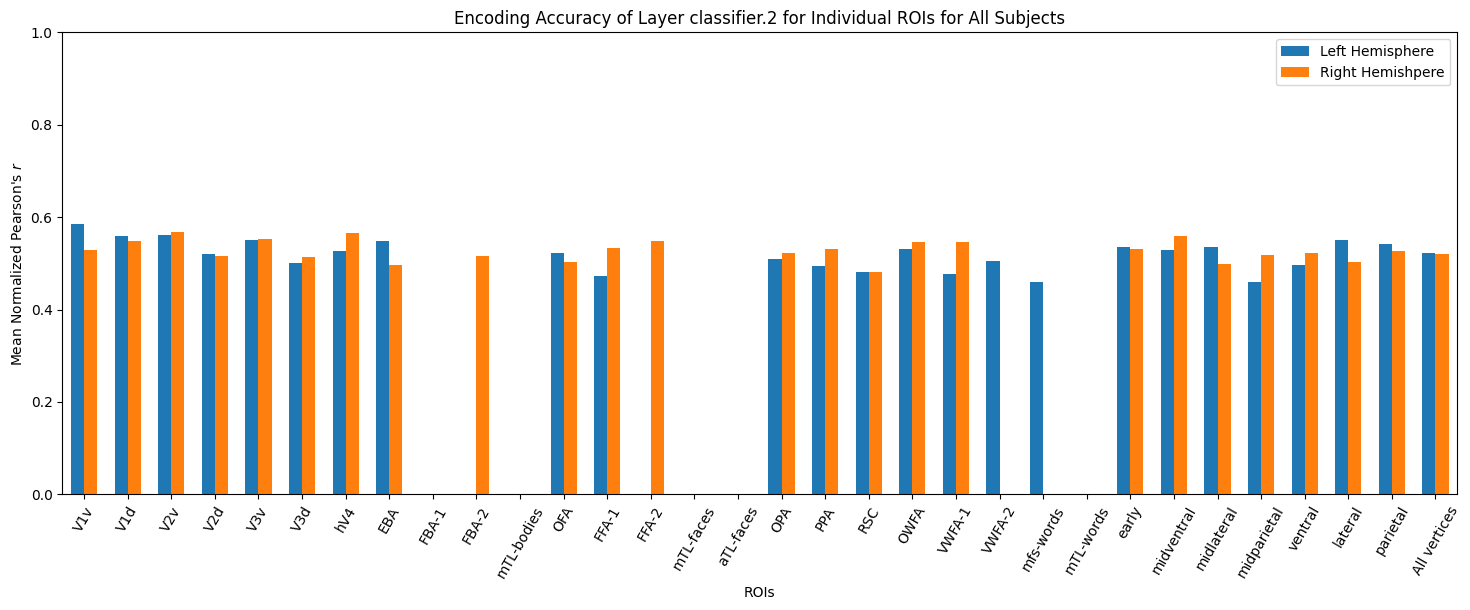

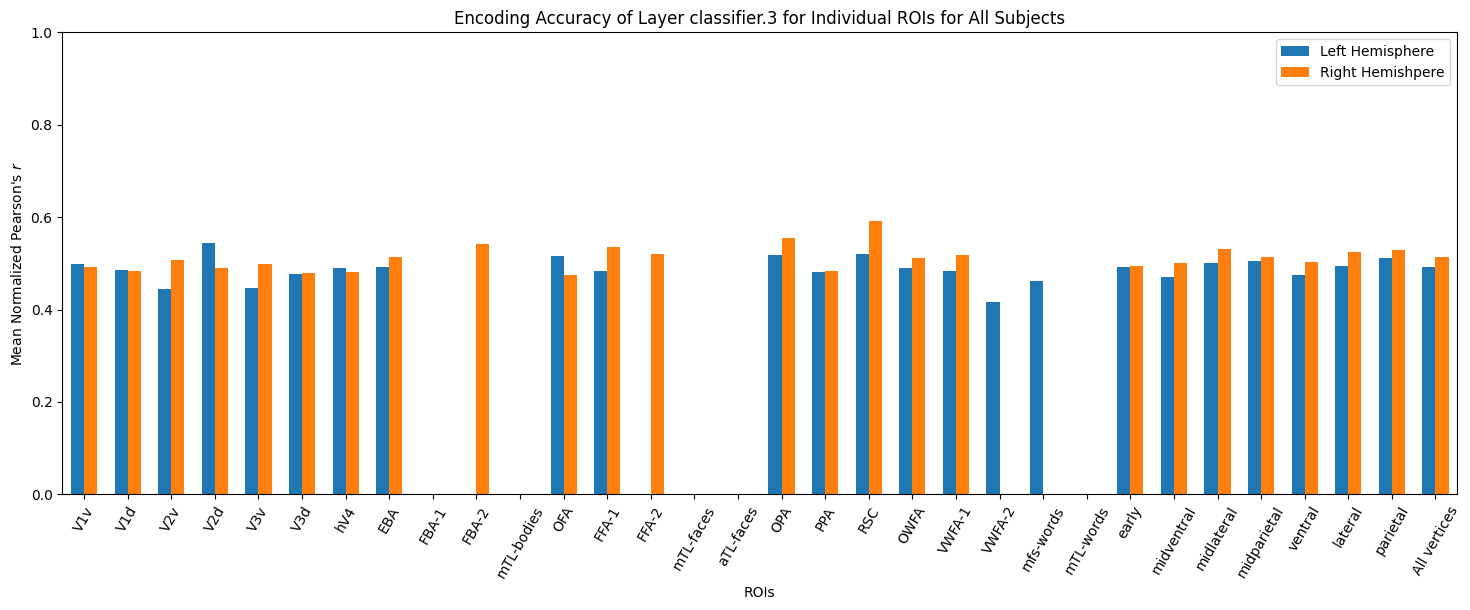

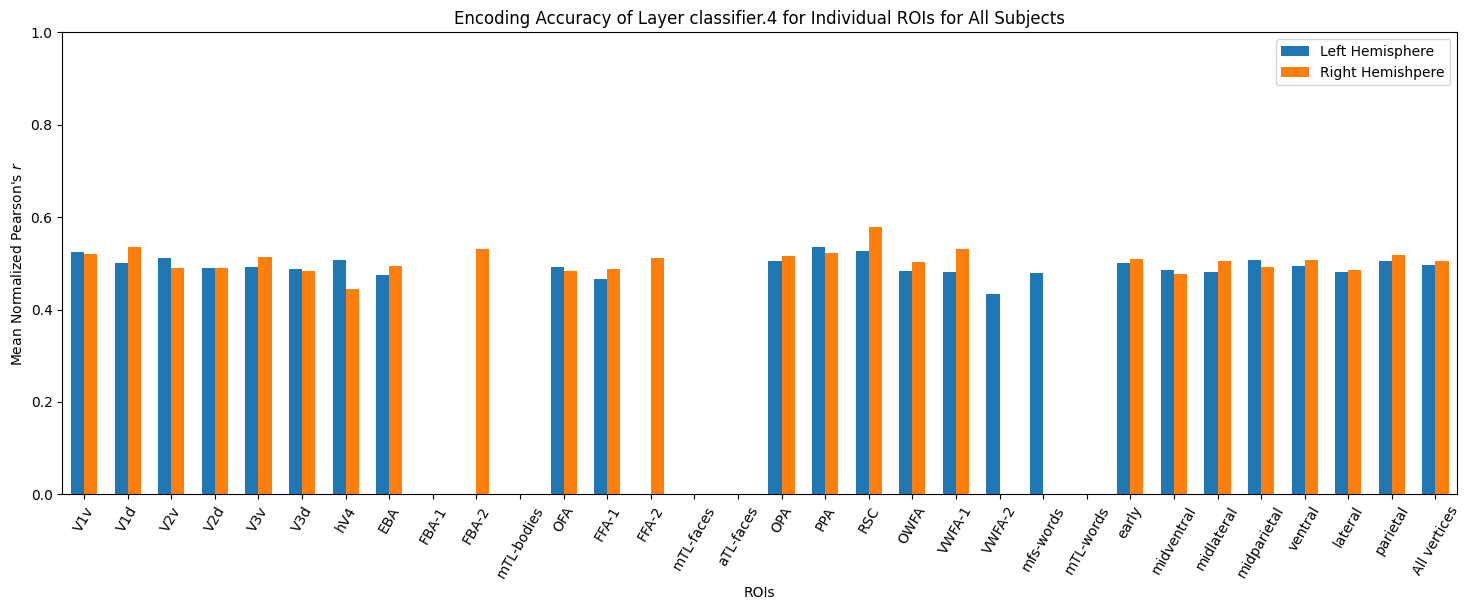

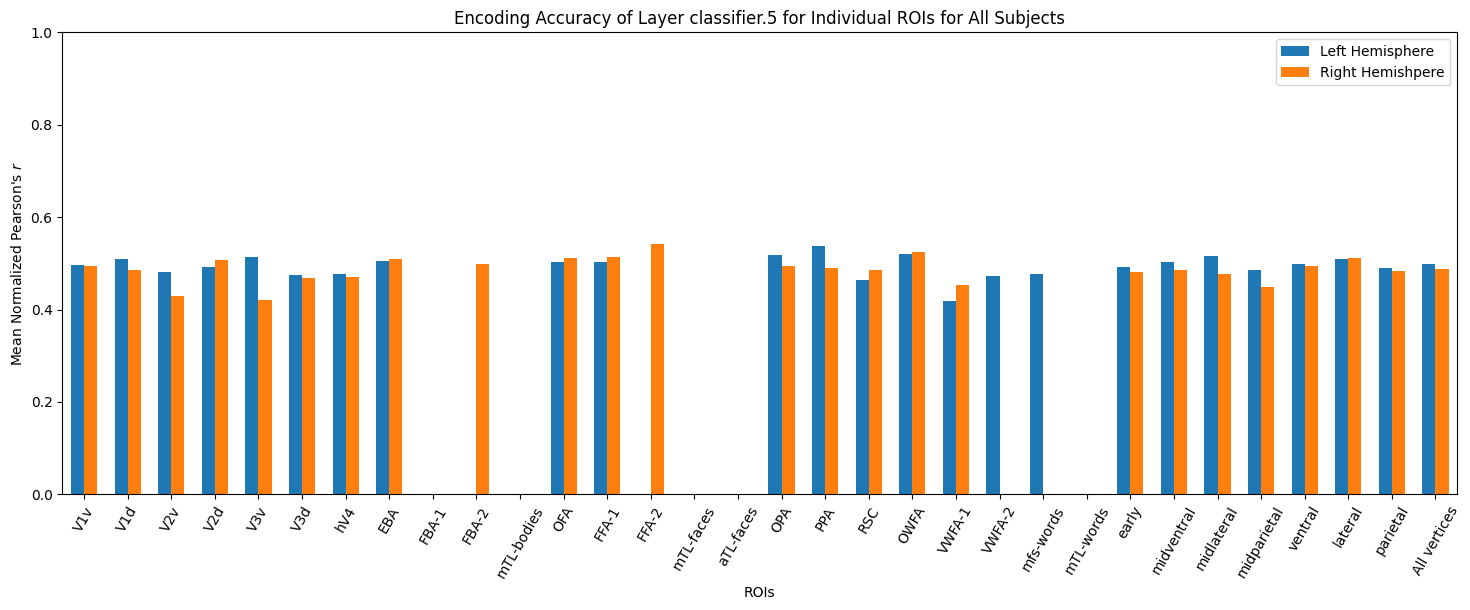

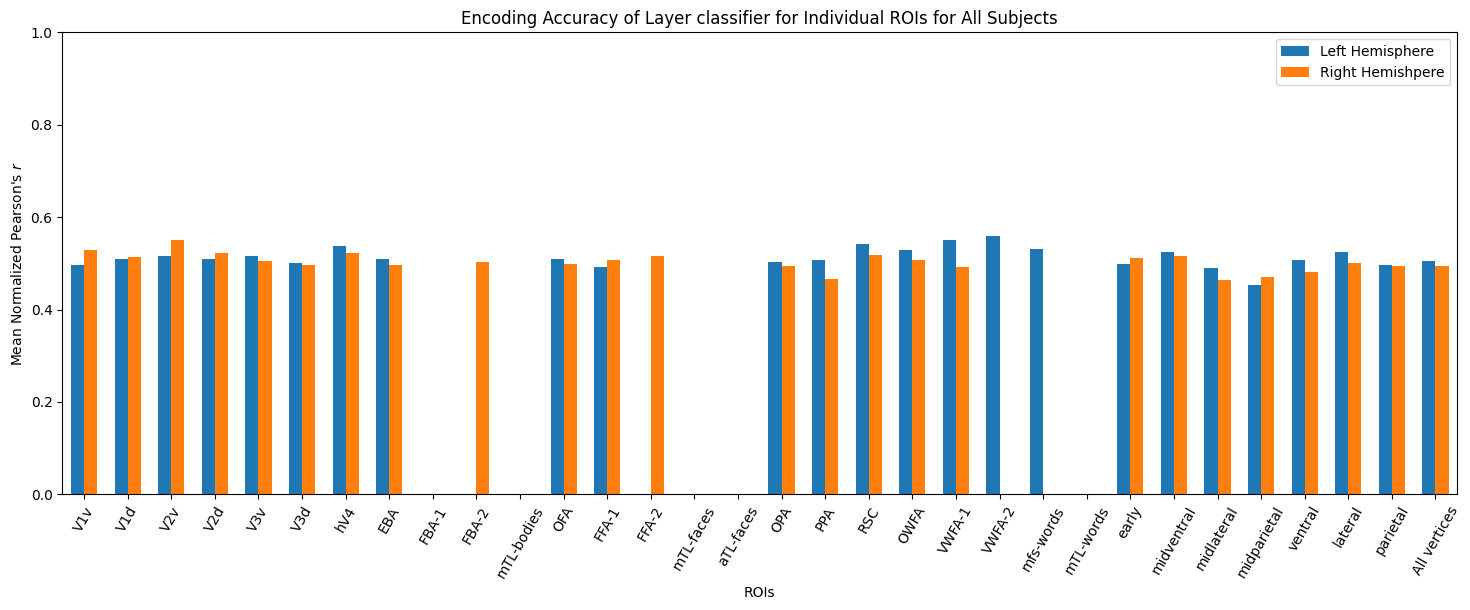

In [6]:
corr_roi_plot_allsub_layers(subject_list= list(range(1,8+1)), first_image_id = 42, last_image_id=46, model = trained_model, feature_extractor=feature_extractor)